In [1]:
import time
tp1 = time.time()

In [2]:
# Some magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [3]:
# Ignore warnings in notebook
import warnings
warnings.filterwarnings('ignore')

In [4]:
# Matplotlib to plot the data
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as patches
plt.rcParams['figure.figsize'] = 8,8
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [5]:
# Some module needed in the notebook
import numpy as np
import javabridge
import bioformats
from itkwidgets import view
from sklearn.externals import joblib

In [6]:
# Create a temporary python PATH to the module that we are using for the analysis
import sys
sys.path.insert(0, "/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/utils")

In [7]:
from chromosome_dsb import *

In [8]:
# Need to create a javabridge to use bioformats to open proprietary format
javabridge.start_vm(class_path=bioformats.JARS)

In [9]:
path_data = '/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/data_chloe/cku-exo1_002/'

In [10]:
position, time_point = load_data.stage_position(path_data)

# Set Parameters

In [11]:
# Size kernel for background substraction, should be a little larger than the object of interest
back_sub_ch1 = 5
back_sub_ch2 = 5
back_sub_ch3 = 20
# FOCI detection:
# Smallest object (in pixels) to be detected
smaller = 1
# Largest object to be detected
largest = 5
# Threshold above which to look for
thresh = 12000

# Find "Skeleton" of gonad

In [12]:
skelete = load_data.skeleton_coord(position,time_point)

Polyfit may be poorly conditioned


# Load Image

In [13]:
path_img = path_data + '/2017-04-12_RAD51-HTP3_cku80-exo1_002_visit_2_D3D_ALX.dv'

In [14]:
image, meta, directory = load_data.load_bioformats(path_img)

# Plot "Skeleton" of gonad

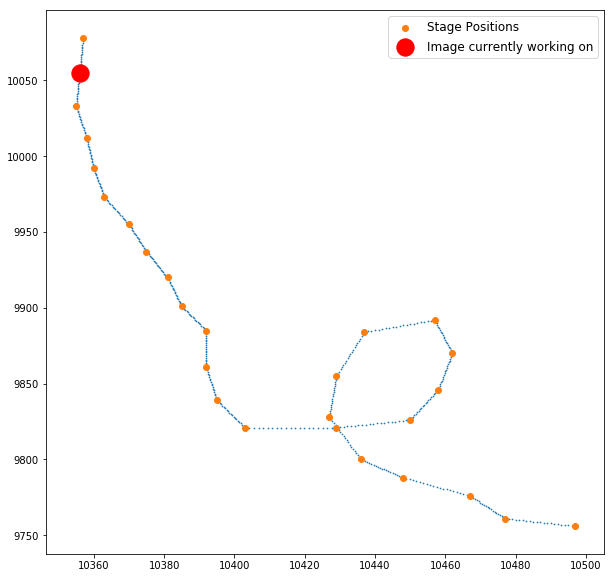

In [15]:
data = np.concatenate((position,time_point[:, np.newaxis]), axis=1)
sort_data = data[np.argsort(data[:,2])]

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.scatter(skelete[:,0], skelete[:,1], s=0.5)
stage_pos = ax.scatter(sort_data[:,0], sort_data[:,1])
working_on = ax.scatter(meta["PositionX"], meta["PositionY"], s=300, color = "r")
plt.legend([stage_pos, working_on], ["Stage Positions", 
                                     "Image currently working on"],
                                      loc=0,fontsize='large')

In [16]:
img = image[:,:,:,3]

In [17]:
view(visualization.convert_view(img))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

# Find the nucleus in the image

### First need to load the classifier (clf) 

In [18]:
clf = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/clf")
scaler = joblib.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/ChromosomeDetectionChloe/clf_scaler/scaler")

In [19]:
tp_1 = time.time()
result = search.rolling_window(img, clf, scaler)
tp_2 = time.time()
print(tp_2-tp_1)

374.1279900074005


In [20]:
bbox_ML = search.non_max_suppression(result, probaThresh=0.01, overlapThresh=0.3)

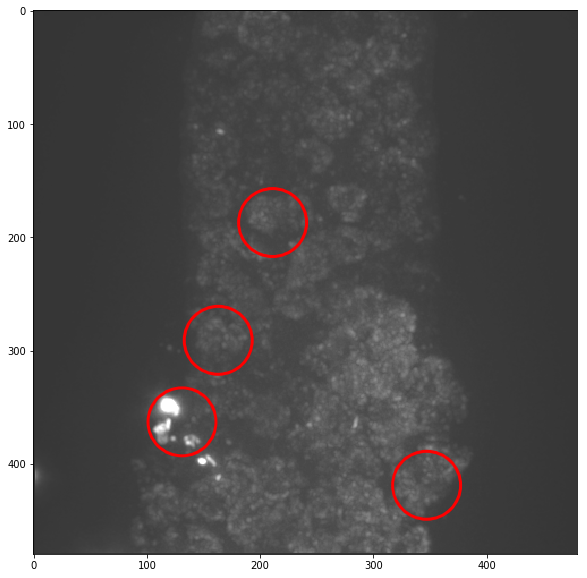

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.imshow(np.amax(img,axis=0), vmax=img.max()/2, alpha = 0.8)
for coord in bbox_ML:
    circles1 = patches.Circle((coord[0]+35,coord[1]+35),30, linewidth=3,edgecolor='r',facecolor='none')
    ax.add_patch(circles1)

# Background Substraction

In [22]:
ch1, _ = img_analysis.background_correct(image, ch=1, size=back_sub_ch1)
ch2, _ = img_analysis.background_correct(image, ch=2, size=back_sub_ch2)
ch3, _ = img_analysis.background_correct(image, ch=3, size=back_sub_ch3)

In [23]:
visualization.plot_background(image, ch1, ch2, ch3)

interactive(children=(IntSlider(value=100, description='pos', max=479), Dropdown(description='channel', option…

# Finding the Blobs/FOCI

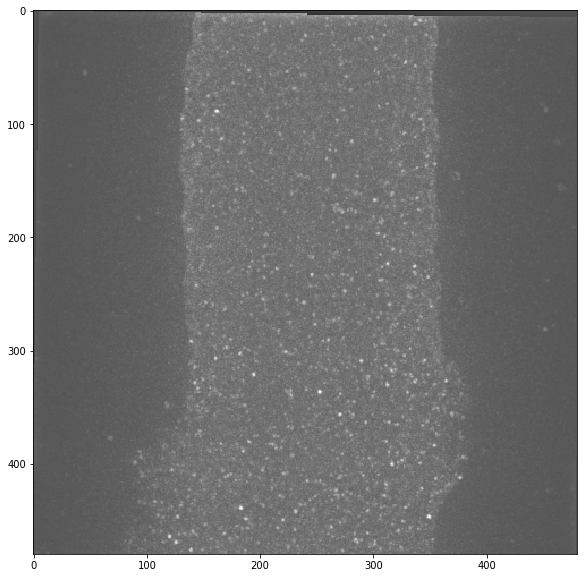

In [24]:
blobs = img_analysis.find_blob(ch1, meta, directory, smaller = smaller, 
                               largest = largest, thresh = thresh,
                               plot=True)

# Binarization of the Channel with nucleus

In [25]:
binary = img_analysis.binarization(ch3)

In [26]:
view(visualization.convert_view(binary))

Viewer(gradient_opacity=0.22, rendered_image=<itkImagePython.itkImageUS3; proxy of <Swig Object of type 'itkIm…

# Load the position of the different nucleus

In [27]:
#bbox_ML = np.load("/Users/Espenel/Desktop/Mini-Grant-Image-analysis/2018/Chloe/13/bbox_3D.npy")

# Mask FOCI that are not on the nucleus

In [28]:
if blobs:
    print("yes")

In [29]:
masked = search.find_foci(blobs, ch1, ch3, binary, bbox_ML)

# Mask FOCI that are not on a nucleus found by the Machine Learning

In [32]:
res, bb_mask = search.binary_select_foci(bbox_ML, ch3, masked)

# Find and remove FOCI that were counted twice

In [33]:
num, cts, dup_idx, mask = search.find_duplicate(res, bb_mask)

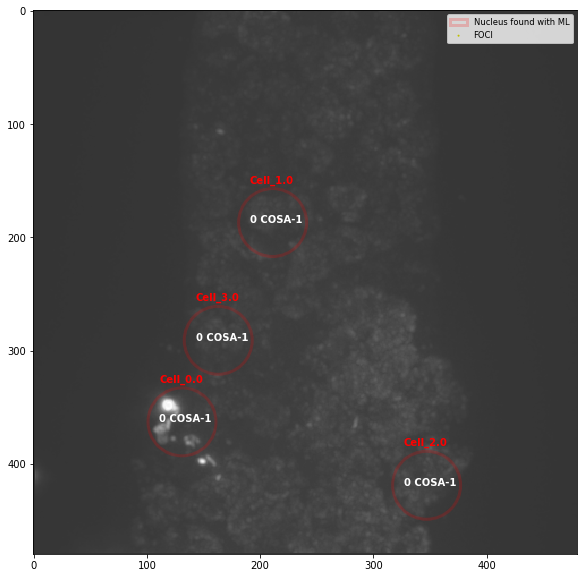

In [34]:
visualization.plot_result(img, res, bbox_ML,\
                          cts, num, meta, directory, save = False)

In [35]:
dist_tip = img_analysis.distance_to_tip(bbox_ML, skelete, meta)

In [57]:
df

,Image ID,"Chromosome position y,x,z",Chromosome position in stage coordinate,distance from tip in um,Numbers of FOCI,cell number on image
0,2,"(131, 363, 28)","(10356, 10055)",40,0,0.0
1,2,"(211, 187, 20)","(10356, 10055)",20,0,1.0
2,2,"(347, 419, 32)","(10356, 10055)",45,0,2.0
3,2,"(163, 291, 56)","(10356, 10055)",32,0,3.0


In [36]:
df = img_analysis.final_table(meta, bbox_ML,  \
                         dist_tip, cts, num, \
                         directory, save = False)

In [37]:
df

,Image ID,"Chromosome position y,x,z",Chromosome position in stage coordinate,distance from tip in um,Numbers of FOCI,cell number on image
0,2,"(131, 363, 28)","(10347, 10045)",40,0,0.0
1,2,"(211, 187, 20)","(10354, 10059)",20,0,1.0
2,2,"(347, 419, 32)","(10365, 10040)",45,0,2.0
3,2,"(163, 291, 56)","(10350, 10051)",32,0,3.0


In [38]:
to_save = {'back_sub_ch1' : back_sub_ch1,
           'back_sub_ch2' : back_sub_ch2,
           'back_sub_ch3' : back_sub_ch3,
           'small_object' : smaller,
           'large_object' : largest,
           'threshold' : thresh}

log.log_file(directory, meta, **to_save)

In [39]:
tp2 = time.time()

In [40]:
print("It took {}sec".format(int(tp2-tp1)))

It took 495sec
